In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [54]:
data = pd.read_csv('../data/processed_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.head()

,wday,month,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,item_id,store_id,cnt,sell_price,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
date,,,,,,,,,,,,,,,
2011-01-29,1,1,1,0,0,0,STORE_2_085,STORE_2,3,1.00,0,0,0,0,1
2011-01-29,1,1,1,0,0,0,STORE_2_043,STORE_2,6,2.88,0,0,0,0,1
2011-01-29,1,1,1,0,0,0,STORE_2_054,STORE_2,6,2.28,0,0,0,0,1
2011-01-29,1,1,1,0,0,0,STORE_2_325,STORE_2,0,NaN,0,0,0,0,1
2011-01-29,1,1,1,0,0,0,STORE_2_090,STORE_2,108,1.25,0,0,0,0,1


In [55]:
store_id = 'STORE_2'

art085=data[(data.item_id==store_id + '_085') & (data.store_id==store_id)]
art085.head(10)

,wday,month,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,item_id,store_id,cnt,sell_price,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
date,,,,,,,,,,,,,,,
2011-01-29,1,1,1,0,0,0,STORE_2_085,STORE_2,3,1.0,0,0,0,0,1
2011-01-30,2,1,2,0,0,0,STORE_2_085,STORE_2,8,1.0,0,0,0,0,1
2011-01-31,3,1,3,0,0,0,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0
2011-02-01,4,2,4,0,1,1,STORE_2_085,STORE_2,3,1.0,0,0,0,0,0
2011-02-02,5,2,5,1,1,0,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0
2011-02-03,6,2,6,1,1,1,STORE_2_085,STORE_2,7,1.0,0,0,0,0,0
2011-02-04,7,2,7,0,1,0,STORE_2_085,STORE_2,4,1.0,0,0,0,0,0
2011-02-05,1,2,8,1,1,1,STORE_2_085,STORE_2,5,1.0,0,0,0,0,1
2011-02-06,2,2,9,1,1,1,STORE_2_085,STORE_2,3,1.0,0,0,0,1,1


In [56]:
from scipy import stats
from statsmodels.tsa.seasonal import STL

transformed_data, lambda_value = stats.boxcox(art085['cnt'] + 1)
stl = STL(pd.Series(transformed_data, index=art085.index), period=7,)
result = stl.fit()

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, acf_lags=100, pacf_lags=30):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    plot_acf(series, lags=acf_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    plot_pacf(series, lags=pacf_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.show()

<Axes: xlabel='date'>

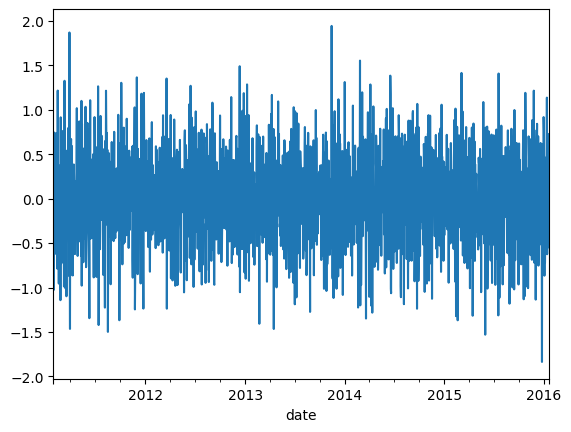

In [58]:
result.resid.plot()

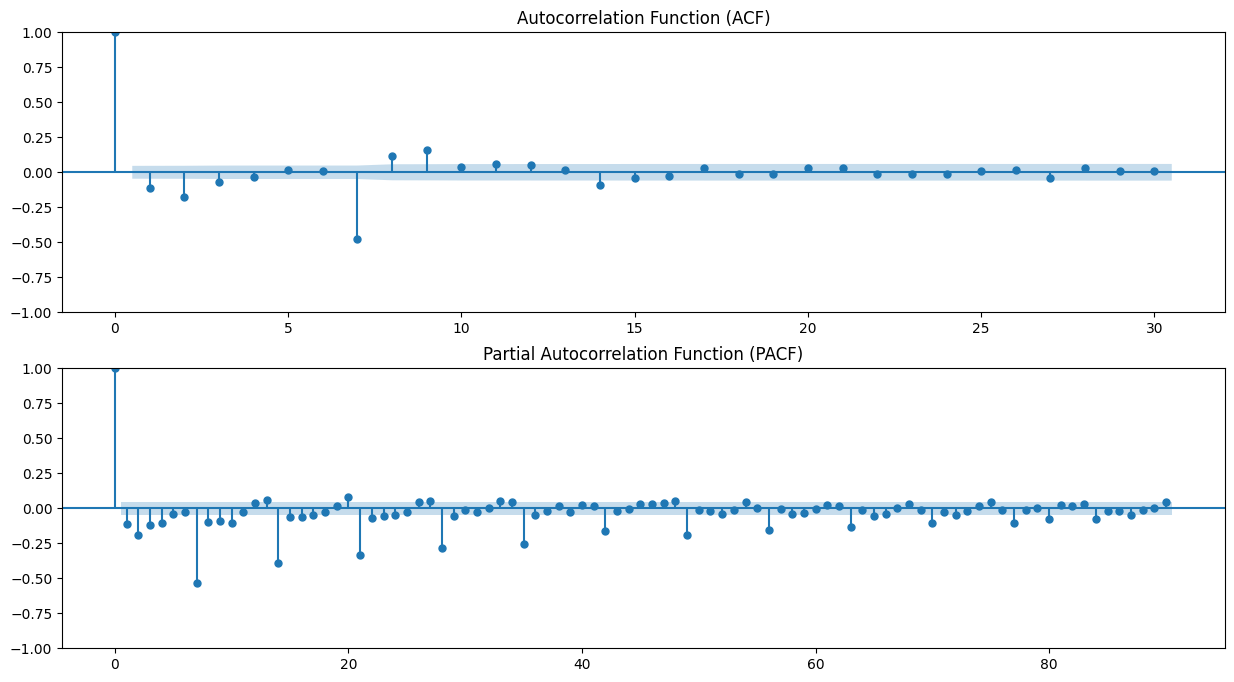

In [70]:
plot_acf_pacf(result.resid, acf_lags=30, pacf_lags=90)

In [68]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y_train, y_test = temporal_train_test_split(result.resid, test_size=90)

fh = ForecastingHorizon(y_test.index, is_relative=False)

model = AutoARIMA(sp=7, seasonal=True, max_p=14, max_q=14, stationary=True)  # sp=365 указывает на годовую сезонность
model.fit(y_train)

y_pred = model.predict(fh)
model.get_fitted_params()

/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

{'intercept': 2.7183297788894015e-05,
 'ar.L1': 0.6888131480695167,
 'ar.L2': -0.13218006100249519,
 'ar.L3': -0.007343420518213207,
 'ar.L4': -0.053230121506946886,
 'ar.L5': 0.005157711726652008,
 'ar.L6': -0.03213677942175391,
 'ma.L1': -0.9731061770135989,
 'ar.S.L7': -0.6622853553980149,
 'ar.S.L14': -0.39048010520892934,
 'sigma2': 0.13634973761570554,
 'order': (6, 0, 1),
 'seasonal_order': (2, 0, 0, 7),
 'aic': 1540.4906202819784,
 'aicc': 1540.6443768341042,
 'bic': 1600.4989036244947,
 'hqic': 1562.6869699681752}

MAE: 0.4139909621242963
MSE: 0.2754447697175014


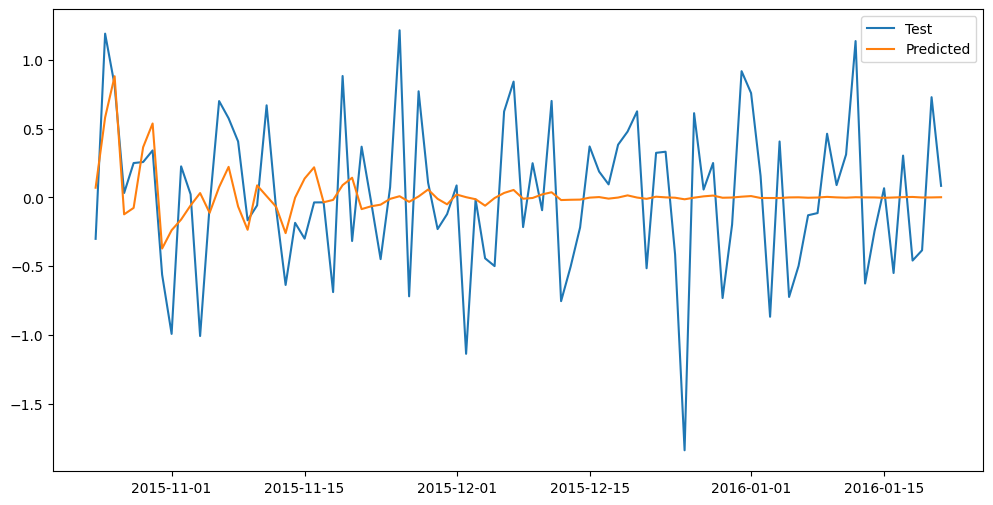

In [69]:
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

plt.figure(figsize=(12, 6))
# plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()